# Assignment 1 - Mirko Michele D'Angelo

For this assignment an autoencoder implementation is needed, so we're gonna implement that first.

In [1]:
import torch
import itertools as it

from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self,encoder_sizes,decoder_sizes):
        super(AutoEncoder, self).__init__()
        encoder_layers=[]
        for sx,dx in it.pairwise(encoder_sizes):
            encoder_layers.append(nn.Linear(sx,dx))
            encoder_layers.append(nn.ReLU())
        decoder_layers=[]
        for sx,dx in it.pairwise(decoder_sizes[:-1]):
            decoder_layers.append(nn.Linear(sx,dx))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_sizes[-2],decoder_sizes[-1]))
        decoder_layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(
            *encoder_layers
        )
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded.requires_grad = True
        encoded.retain_grad()
        decoded = self.decoder(encoded)
        return encoded, decoded

The implementation is straightforward in pytorch, for this i decided to use ReLu's as activations functions and a sigmoidal function for the output layer so that we can avoid gradient vanish for autoencoders with a lot of layers.

Next we download our dataset thorugh pytorch.

In [2]:

import torchvision
import torchvision.transforms as transforms
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataset.requires_grad=True
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First we implement the denoising autoencoder, the implementation is simple we just need to add random noise to the image and feed is input while we use the original as target.

In [4]:
import matplotlib.pyplot as plt 
def train_denoising_ae(ae,data,n_epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        total_loss = 0
        for sample in data:
            img, _ = sample
            img_noisy = img + torch.randn(img.size())
            img_noisy = img_noisy.view(-1, 28*28)
            img = img.view(-1, 28*28)
            optimizer.zero_grad()

            img=img.to(DEVICE)
            img_noisy=img_noisy.to(DEVICE)
            _, output = ae(img_noisy)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            MSE_loss = nn.MSELoss()(output, img)
            total_loss += MSE_loss.item()
        avg_loss = total_loss / len(data)   
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{avg_loss:.4f}')
dae=AutoEncoder([28*28, 256, 64], [64,256, 28*28]).to(DEVICE)
train_denoising_ae(dae,dataloader,20)

epoch [1/20], loss:0.0535
epoch [2/20], loss:0.0354
epoch [3/20], loss:0.0321
epoch [4/20], loss:0.0303
epoch [5/20], loss:0.0293
epoch [6/20], loss:0.0286
epoch [7/20], loss:0.0280
epoch [8/20], loss:0.0276
epoch [9/20], loss:0.0273
epoch [10/20], loss:0.0270
epoch [11/20], loss:0.0269
epoch [12/20], loss:0.0266
epoch [13/20], loss:0.0265
epoch [14/20], loss:0.0263
epoch [15/20], loss:0.0262
epoch [16/20], loss:0.0260
epoch [17/20], loss:0.0259
epoch [18/20], loss:0.0258
epoch [19/20], loss:0.0258
epoch [20/20], loss:0.0257


For the contractive autoencoder we need to do a slightly more complicated implementation, first we need to implement the contractive loss,to do so we have to compute the gradient of the encoder part of the AE w.r.t. the inputs in order to obtain our jacobian then we can sum it to our choosen loss and backpropagate as normal.

In [83]:
def contractive_loss(encoder_output,criterion, inputs,outputs,contractive_penalty):
    loss1=criterion(outputs,inputs)
    encoder_output.backward(torch.ones(encoder_output.size()).to(DEVICE), retain_graph=True)
    loss2= torch.sqrt(torch.sum(torch.pow(inputs.grad,2)))
    return loss1+(contractive_penalty*loss2)

def train_contractive_ae(ae,data,n_epochs=10,contractive_penalty=1e-10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        ae.train()
        total_loss = 0
        for i,sample in enumerate(data):
            batch, _ = sample
            batch = batch.view(-1, 28*28).to(DEVICE)
            
            batch.requires_grad = True
            batch.retain_grad()
            hidden, output = ae(batch)
            loss=contractive_loss(hidden,nn.BCELoss(),batch,output,contractive_penalty)
            batch.requires_grad=False
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            MSE_loss = nn.MSELoss()(output, batch)
            total_loss += MSE_loss.item()
        avg_loss = total_loss / len(data)
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{avg_loss:.4f}')
#needed in order to compute the jacobian

cae=AutoEncoder([28*28, 256, 64,16], [16,64, 256, 28*28]).to(DEVICE)
train_contractive_ae(cae,dataloader,100)

epoch [1/100], loss:0.0604
epoch [2/100], loss:0.0327
epoch [3/100], loss:0.0253
epoch [4/100], loss:0.0218
epoch [5/100], loss:0.0198
epoch [6/100], loss:0.0182
epoch [7/100], loss:0.0171
epoch [8/100], loss:0.0161
epoch [9/100], loss:0.0153
epoch [10/100], loss:0.0148
epoch [11/100], loss:0.0144
epoch [12/100], loss:0.0140
epoch [13/100], loss:0.0138
epoch [14/100], loss:0.0135
epoch [15/100], loss:0.0133
epoch [16/100], loss:0.0131
epoch [17/100], loss:0.0130
epoch [18/100], loss:0.0128
epoch [19/100], loss:0.0127
epoch [20/100], loss:0.0126
epoch [21/100], loss:0.0124
epoch [22/100], loss:0.0124
epoch [23/100], loss:0.0123
epoch [24/100], loss:0.0122
epoch [25/100], loss:0.0121
epoch [26/100], loss:0.0120
epoch [27/100], loss:0.0119
epoch [28/100], loss:0.0119
epoch [29/100], loss:0.0118
epoch [30/100], loss:0.0117
epoch [31/100], loss:0.0117
epoch [32/100], loss:0.0116
epoch [33/100], loss:0.0116
epoch [34/100], loss:0.0115
epoch [35/100], loss:0.0115
epoch [36/100], loss:0.0115
e

Now we can test the AE's capabilities of converging to the manifold from noise.
First we need to apply the gradient descent algorithm, to do so the output of an AE is feed to it as an input until we see that there is small difference between the current output and the previous output, if thats the case we should have reached the manifold.

In [75]:
def generate_data_point(model, noise, num_iterations=20000):
    old_noise=noise
    diff=1
    # Start with a random noise
    while(diff > 1e-3 and num_iterations>0):
        old_noise=noise
        _,noise = model(old_noise)
        diff=torch.norm(noise-old_noise,p=2)
        num_iterations-=1
    if num_iterations==0:
        print("maximum number of iterations reached")
    new_data_point= noise.view(-1, 28*28)
    return new_data_point

Now we can analyze our reconstrunctions, in order to do this we randomly generate a certain number of samples and plot the results of the gradient ascent algorithm for the contractive and denosing autoencoders.

maximum number of iterations reached


Text(0.5, 0.98, 'CAE reconstrunctions')

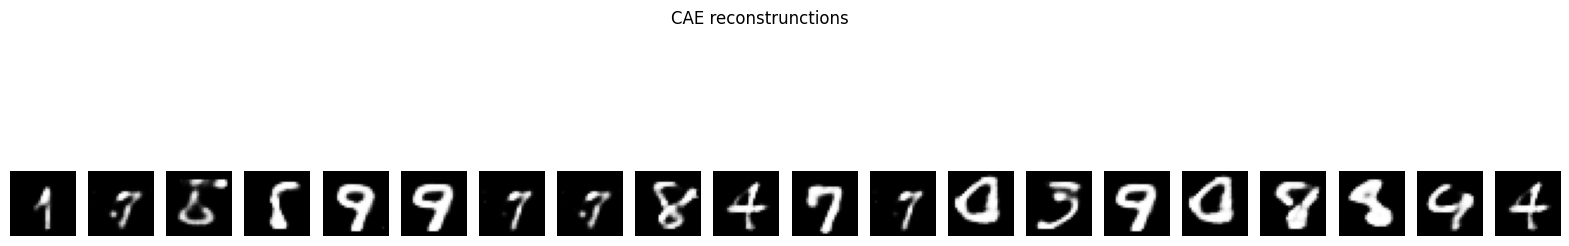

In [84]:
import matplotlib.pyplot as plt
num_samples=20
torch.manual_seed(42)
noise=torch.randn((num_samples,28*28)).requires_grad_(True).to(DEVICE)
plt.figure(figsize=(20, 4))
for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(generate_data_point(cae,noise[i]).view(28, 28).detach().cpu().numpy(),cmap='gray')
    plt.axis('off')
plt.suptitle('CAE reconstrunctions')

Text(0.5, 0.98, 'DAE reconstrunctions')

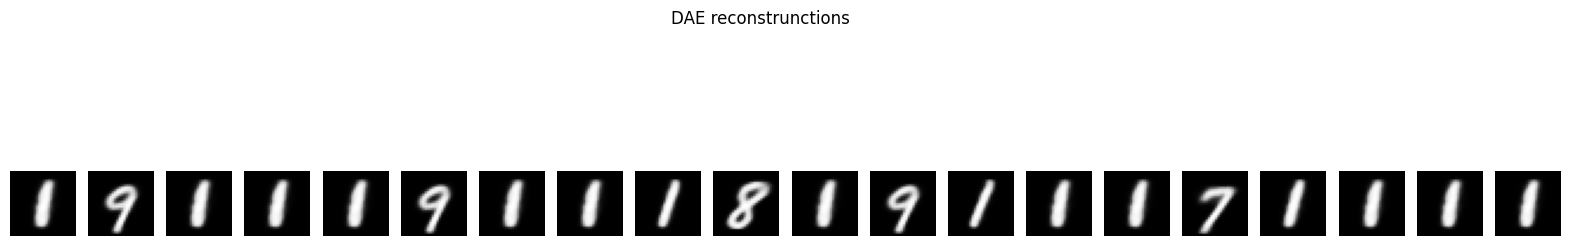

In [74]:
plt.figure(figsize=(20, 4))
for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(generate_data_point(dae,noise[i]).view(28, 28).detach().cpu().numpy(),cmap='gray')
    plt.axis('off')
plt.suptitle('DAE reconstrunctions')

As we can see the first thing we notice is the shape of the numbers, in the CAE they are not fully formed and in some parts they tend to be faded while for the DAE numbers are fully formed and clearly defined.

Also we can see that the encoders show some kind of "preference", the CAE tends to reconstruct 7's and 5's while the DAE tends to reconstruct 1's,9's.

Both models manage to converge to the manifold but the DAE clearly tends to have a better reconstruction, also the CAE works but requires much more training and fine tuning in order to reach valid results.